In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns
import tensorflow as tf
import utils

In [2]:
data_directory='/n/projects/smc/public/SMC/DLRegistration/BrainSlices/'

In [51]:
shp=[1,256,256,1]

In [52]:
raw=utils.get_raw_float_image(data_directory+'BrainSmaller.raw',shp)

In [141]:
def generate_batch(batch_size, rotation_range, shifting_range, raw_range):
    
    idices=np.random.choice(raw_range, size=batch_size)
    base=raw[idices,:,:]
    base=list(map(lambda x: sp.ndimage.rotate(x,np.random.uniform(-180, 180), reshape=False), base))
    base=np.stack(base)
    
    rotates=np.random.uniform(-rotation_range,rotation_range, size=batch_size)
    shifts=np.random.uniform(-shifting_range,shifting_range, size=[batch_size,2])
    truth=np.stack([rotates, shifts[:,0], shifts[:,1]], axis=1)
    
    dat=np.stack([sp.ndimage.rotate(sp.ndimage.shift(base[n], truth[n,1:3]), truth[n,0], reshape=False ) for n in range(0,batch_size)])
    altered=np.stack([base[n] for n in range(0,batch_size)])
    
    #truth[:,0]=truth[:,0]
    #truth[:,1:3]=truth[:,1:3]
    data=np.ndarray([batch_size,256,256,2])
    data[:,:,:,0]=base
    data[:,:,:,1]=dat
    
    data=data[:,64:192, 64:192,:]
    altered=np.reshape(altered[:,64:192, 64:192], [altered.shape[0],128,128,1])
    return (data, altered, truth)

In [225]:
remake=True

training_data=0
training_truth=0
if remake:
    training_data, training_altered, training_truth=generate_batch(10000,rotation_range=50,shifting_range=0.2, raw_range=range(100,raw.shape[0]-20))
    np.save(data_directory+'training_data', training_data)
    np.save(data_directory+'training_altered', training_altered)
    np.save(data_directory+'training_truth', training_truth)
else:
    training_data=np.load(data_directory+'training_data.npy')
    training_altered=np.load(data_directory+'training_altered.npy')
    training_truth=np.load(data_directory+'training_truth.npy')

mean=np.mean(training_data)
std=np.std(training_data)

training_data=(training_data-mean)/std+0.5
training_altered=(training_altered-mean)/std+0.5

In [226]:
validation_data,validation_altered, validation_truth=generate_batch(100,rotation_range=50,shifting_range=0.2, raw_range=range(0,100))
validation_data=(validation_data-mean)/std+0.5
validation_altered=(validation_altered-mean)/std+0.5

In [227]:
tf.reset_default_graph()
#Input and output
x=tf.placeholder(dtype=tf.float32, shape=[None, 128,128,2])
y=tf.placeholder(dtype=tf.float32, shape=[None,128,128,1])
z=tf.placeholder(dtype=tf.float32, shape=[None, 3])

lr=tf.placeholder(dtype=tf.float32, shape=[], name='learning_rate')

xr=x
yr=y
zr=z

base_scaler=16

regularizer = tf.contrib.layers.l2_regularizer(scale=0.1)

#Going down
A1=utils.leaky_relu(tf.layers.conv2d(xr, base_scaler, [5,5], padding='SAME', kernel_regularizer=regularizer))
A2=utils.leaky_relu(tf.layers.conv2d(A1, base_scaler, [3,3], padding='SAME', kernel_regularizer=regularizer))

B0=tf.nn.max_pool(A2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
B1=utils.leaky_relu(tf.layers.conv2d(B0, 2*base_scaler, [3,3], padding='SAME', kernel_regularizer=regularizer))
B2=utils.leaky_relu(tf.layers.conv2d(B1, 2*base_scaler, [3,3], padding='SAME', kernel_regularizer=regularizer))

C0=tf.nn.max_pool(B2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
C1=utils.leaky_relu(tf.layers.conv2d(C0, 4*base_scaler, [3,3], padding='SAME', kernel_regularizer=regularizer))
C2=utils.leaky_relu(tf.layers.conv2d(C1, 4*base_scaler, [3,3], padding='SAME', kernel_regularizer=regularizer))

D0=tf.nn.max_pool(C2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
D1=utils.leaky_relu(tf.layers.conv2d(D0, 8*base_scaler, [3,3], padding='SAME', kernel_regularizer=regularizer))
D2=utils.leaky_relu(tf.layers.conv2d(D1, 8*base_scaler, [3,3], padding='SAME', kernel_regularizer=regularizer))

E0=tf.nn.max_pool(D2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
E1=utils.leaky_relu(tf.layers.conv2d(E0, 16*base_scaler, [3,3], padding='SAME', kernel_regularizer=regularizer))
E2=utils.leaky_relu(tf.layers.conv2d(E1, 16*base_scaler, [3,3], padding='SAME', kernel_regularizer=regularizer))

Flat=tf.reshape(E2, [-1, 8*8*16*base_scaler])
Dense=tf.layers.dense(Flat, 1024)
FlatDense=tf.layers.dense(Dense, 8*8*16*base_scaler)
FF0=tf.reshape(FlatDense, [-1, 8, 8, 16*base_scaler])

#Coming up
DD0=tf.layers.conv2d_transpose(FF0, 8*base_scaler, kernel_size=[3,3], strides=[2, 2], padding='SAME')
#DD1=tf.concat(axis=3, values=[DD0,D2])
DD2=utils.leaky_relu(tf.layers.conv2d(DD0, 8*base_scaler, [3,3], padding='SAME', kernel_regularizer=regularizer))
DD3=utils.leaky_relu(tf.layers.conv2d(DD2, 8*base_scaler, [3,3], padding='SAME', kernel_regularizer=regularizer))

CC0=tf.layers.conv2d_transpose(DD3, 4*base_scaler, kernel_size=[3,3], strides=[2, 2], padding='SAME')
#CC1=tf.concat(axis=3, values=[CC0,C2])
CC2=utils.leaky_relu(tf.layers.conv2d(CC0, 4*base_scaler, [3,3], padding='SAME', kernel_regularizer=regularizer))
CC3=utils.leaky_relu(tf.layers.conv2d(CC2, 4*base_scaler, [3,3], padding='SAME', kernel_regularizer=regularizer))

BB0=tf.layers.conv2d_transpose(CC3, 2*base_scaler, kernel_size=[3,3], strides=[2, 2], padding='SAME')
#BB1=tf.concat(axis=3, values=[BB0,B2])
BB2=utils.leaky_relu(tf.layers.conv2d(BB0, 2*base_scaler, [3,3], padding='SAME', kernel_regularizer=regularizer))
BB3=utils.leaky_relu(tf.layers.conv2d(BB2, 2*base_scaler, [3,3], padding='SAME', kernel_regularizer=regularizer))

AA0=tf.layers.conv2d_transpose(BB3, base_scaler, kernel_size=[3,3], strides=[2, 2], padding='SAME')
AA1=tf.concat(axis=3, values=[AA0,tf.reshape(x[:,:,:,1],[-1,128,128,1])])
AA2=utils.leaky_relu(tf.layers.conv2d(AA1, base_scaler, [3,3], padding='SAME', kernel_regularizer=regularizer))
AA3=utils.leaky_relu(tf.layers.conv2d(AA2, base_scaler, [3,3], padding='SAME', dilation_rate=2,kernel_regularizer=regularizer))
AA4=utils.leaky_relu(tf.layers.conv2d(AA3, base_scaler, [3,3], padding='SAME', dilation_rate=3,kernel_regularizer=regularizer))
AA5=utils.leaky_relu(tf.layers.conv2d(AA4, base_scaler, [3,3], padding='SAME', dilation_rate=4,kernel_regularizer=regularizer))
AA6=utils.leaky_relu(tf.layers.conv2d(AA2, base_scaler, [3,3], padding='SAME', kernel_regularizer=regularizer))

logits=utils.leaky_relu(tf.layers.conv2d(AA6, 1, [1,1], padding='SAME', kernel_regularizer=regularizer))
#probs=tf.tanh(logits, name='probabilities')
probs=logits

P1=tf.layers.dense(FlatDense, 128)
parameters=tf.layers.dense(P1,3)

pix_diff=tf.subtract(probs, yr)
pix_LSQ=tf.multiply(pix_diff,pix_diff)

par_diff=tf.subtract(parameters, zr)
par_LSQ=tf.multiply(par_diff, par_diff)
#Added this to make the outlines more potent in error function
#OutError, MaskError=tf.split(LSQ, [1,1], 3)
#loss=1*tf.reduce_mean(OutError)+0.1*tf.reduce_mean(MaskError)
loss=10*tf.reduce_mean(par_LSQ)
l2_loss = tf.losses.get_regularization_loss()
#loss=loss+l2_loss/1000

train_op=tf.train.AdamOptimizer(learning_rate=lr, name='trainer').minimize(loss)

In [228]:
tf.set_random_seed(123456)
sess=tf.Session()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver(max_to_keep=50)
for f in range(0,20000):
    idx=np.random.choice(training_data.shape[0], replace=False, size=[40])
    cur_train=training_data[idx,:,:,:]
    cur_altered=training_altered[idx,:,:,:]
    cur_truth=training_truth[idx,:]
    
    _,results, losses=sess.run([train_op, logits, loss], feed_dict={x:cur_train, y:cur_altered, z:cur_truth, lr:0.0003})
    if (f%100==0):
        res, pars, valid_loss=sess.run([logits,parameters,loss], feed_dict={x:validation_data, y:validation_altered, z:validation_truth})
        print([f,losses, valid_loss])
        #utils.plot_4x1(validation_data[0,:,:,0], validation_data[0,:,:,1], validation_altered[0,:,:,0], res[0,:,:,0])
        #print(cur_truth[0,:])
        #print(pars[0,:])
        #plt.show()
        #saver.save(sess, data_directory+'NewModels/Model'+str(f))
    

[0, 3123.7563, 2916.608]
[100, 494.36346, 884.9838]
[200, 259.28622, 558.22424]
[300, 280.02832, 759.9829]
[400, 102.28969, 433.28366]
[500, 61.454666, 434.35217]
[600, 62.229355, 359.45248]
[700, 24.89568, 430.42004]
[800, 28.544075, 396.67358]
[900, 60.478462, 360.09082]
[1000, 22.182262, 346.4234]
[1100, 65.7351, 374.34686]
[1200, 42.831005, 438.54187]
[1300, 18.656443, 372.0454]
[1400, 33.898224, 352.90494]
[1500, 20.123055, 381.7379]
[1600, 12.073249, 399.23773]
[1700, 148.22096, 384.8218]
[1800, 30.836758, 379.99414]
[1900, 51.47863, 318.1267]
[2000, 18.800304, 372.72314]
[2100, 15.850949, 379.88922]
[2200, 35.438393, 330.76538]
[2300, 16.728788, 357.89368]
[2400, 33.09005, 341.61475]
[2500, 74.793076, 401.6727]
[2600, 13.172845, 383.57632]
[2700, 18.016932, 326.5933]
[2800, 22.440092, 372.08118]
[2900, 15.430399, 345.70328]
[3000, 30.435764, 369.72424]
[3100, 24.163916, 376.1752]
[3200, 17.74854, 310.5244]
[3300, 21.150522, 426.6365]
[3400, 13.281432, 360.65305]
[3500, 18.240221

KeyboardInterrupt: 

In [229]:
res,pars, valid_loss=sess.run([logits,parameters, loss], feed_dict={x:validation_data, y:validation_altered, z:validation_truth})

In [250]:
idx=np.random.randint(0,100)
print(validation_truth[idx])
print(pars[idx])

[ 2.50293118e+01 -4.96095139e-02  2.36492735e-02]
[2.2781288e+01 1.2515881e-02 7.5031780e-02]


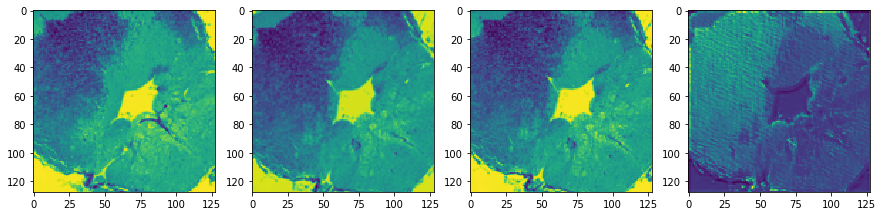

In [79]:
idx=np.random.randint(0,100)
utils.plot_4x1(validation_data[idx,:,:,0], validation_data[idx,:,:,1], validation_altered[idx,:,:,0], res[idx,:,:,0])

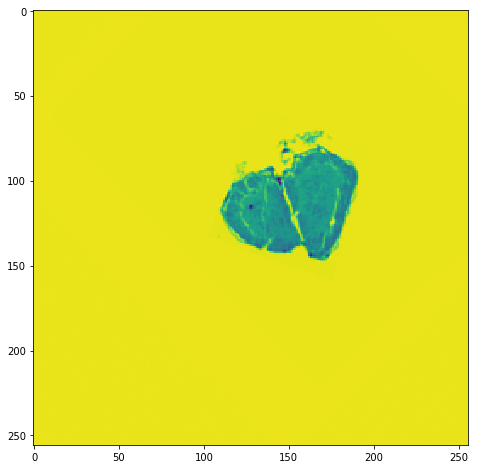

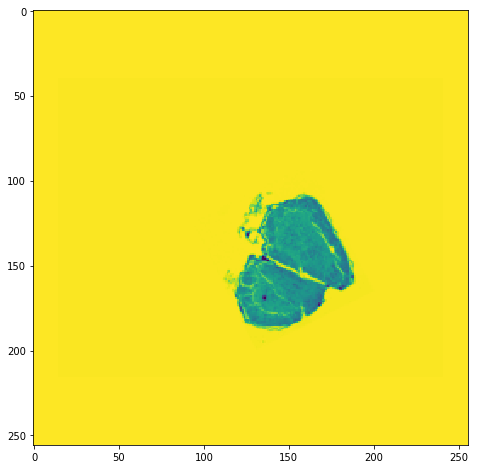

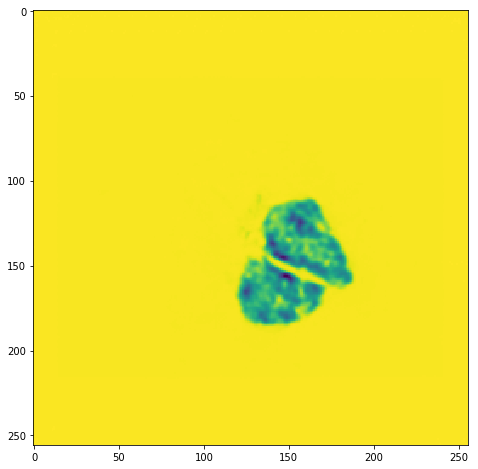

In [20]:
idx=np.random.randint(0,100)
plt.figure(figsize=[8,8])
plt.imshow(validation_data[idx,:,:,1])
plt.figure(figsize=[8,8])
plt.imshow(validation_truth[idx,:,:,0])
plt.figure(figsize=[8,8])
plt.imshow(res[idx,:,:,0])

In [52]:
idx=np.random.randint(0,100)
print(idx)
print(res[idx,:])
print(validation_truth[idx,:])

26
[-104.790146   42.04472    42.314995]
[-127.96739047   46.01618485   48.00432569]
